In [3]:
from DataSimulations import simulate
from Data import DataSet
from Models.LSTM_VAR import LSTM_VAR
import logging
import Train
from Train import set_seed
import keras
from HelpComputation import *
from HelpLatex import *
from HelpPlot import *
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Experiment 1: Changing the number of units in the LSTM-VAR model

In [4]:
n, m, p = 1000, 3, 4
test = 'Experiment1UnitSize'
unit_options = [1, 4, 8, 32, 64, 128, 256]

# Run Experiment

In [6]:
var_results = []
for seed in range(0, 10):
    print('Simulation',seed)
    set_seed(seed)
    # Simulate Data
    simulation = simulate(n, m, p, seed=seed)
    param = simulation['parameters']
    data = simulation['v']
    dataset = DataSet(data.values).preprocessing(1, p, 0.8, 0.1, scale=False) # Include p lags in X, forecast horizon = 1
    
    # VAR
    var_coefs = VAR.get_var_coefficients(dataset.train,p)
    var_eval = Evaluation.matrix_rmse(var_coefs, param['companion_matrix'][:param['m']])
    var_eval['test_rmse'] = Evaluation.root_mean_squared_error(VAR.predict(var_coefs, dataset.test), dataset.test[param['p']:])
    var_eval['model'] = 'VAR'
    var_eval['simulation'] = param['seed']
    var_results.append(var_eval)
    
    # LSTM-VAR
    models = {'LSTM-VAR: '+str(model.units)+' unit(s)':model for model in [LSTM_VAR(m, p=param['p'], units=units, scaler=dataset.scaler) for units in unit_options]}
    models_results = {'metrics':[], 'gradients':[]}
    for model_name in models:
        print(model_name, end=' ')
        trained_model, model_eval = Train.train_model(model=models[model_name],dataset=dataset, param=param, epochs=200, verbose=2)
        if seed==0:
            # replace : with "" to avoid problems with saving
            trained_model.save(test+'/models/'+model_name.replace(':',''), save_format="tf")
        t1 = model_eval['metrics']
        t1['model'] = model_name
        t1['simulation'] = param['seed']
        
        t2 = model_eval['gradients']
        t2['model'] = model_name
        t2['simulation'] = param['seed']
        
        models_results['metrics'].append(t1)
        models_results['gradients'].append(t2)
    save(pd.concat(models_results['metrics']), f'metrics_sim{seed}', test+'/results')
    save(pd.concat(models_results['gradients']), f'gradients_sim{seed}', test+'/results')
    
save(pd.DataFrame(var_results), 'var_results', test+'/results')

Simulation 0
LSTM-VAR: 1 unit(s) Epoch 1/200
25/25 - 2s - loss: 1.8055 - val_loss: 1.4961 - 2s/epoch - 96ms/step
Epoch 2/200
25/25 - 0s - loss: 1.4237 - val_loss: 1.2157 - 135ms/epoch - 5ms/step
Epoch 3/200
25/25 - 0s - loss: 1.2025 - val_loss: 1.0778 - 137ms/epoch - 5ms/step
Epoch 4/200
25/25 - 0s - loss: 1.0996 - val_loss: 1.0236 - 132ms/epoch - 5ms/step
Epoch 5/200
25/25 - 0s - loss: 1.0485 - val_loss: 0.9980 - 130ms/epoch - 5ms/step
Epoch 6/200
25/25 - 0s - loss: 1.0174 - val_loss: 0.9804 - 131ms/epoch - 5ms/step
Epoch 7/200
25/25 - 0s - loss: 0.9964 - val_loss: 0.9719 - 138ms/epoch - 6ms/step
Epoch 8/200
25/25 - 0s - loss: 0.9817 - val_loss: 0.9652 - 130ms/epoch - 5ms/step
Epoch 9/200
25/25 - 0s - loss: 0.9705 - val_loss: 0.9586 - 127ms/epoch - 5ms/step
Epoch 10/200
25/25 - 0s - loss: 0.9632 - val_loss: 0.9570 - 126ms/epoch - 5ms/step
Epoch 11/200
25/25 - 0s - loss: 0.9579 - val_loss: 0.9564 - 124ms/epoch - 5ms/step
Epoch 12/200
25/25 - 0s - loss: 0.9537 - val_loss: 0.9555 - 127ms

# Plotting

In [5]:
# Remember to change based on experiment
vars = ['VAR']
lstm_vars = ['LSTM-VAR: '+str(units)+' unit(s)' for units in unit_options]
counterparts = vars*len(lstm_vars) # can be list of lists if true model is known

In [6]:
order = vars + lstm_vars
palette = sns.color_palette("Set1", n_colors=len(order))
metrics = rename_columns(pd.concat([pd.read_csv(test+'/results/'+file) for file in os.listdir(test+'/results') if 'metrics_sim' in file]).reset_index(drop=True))
gradients = rename_variables(rename_columns(pd.concat([pd.read_csv(test+'/results/'+file) for file in os.listdir(test+'/results') if 'gradients_sim' in file]).reset_index(drop=True)))
var_results = rename_columns(pd.read_csv(test+'/results/var_results.csv'))

## Performance over epochs

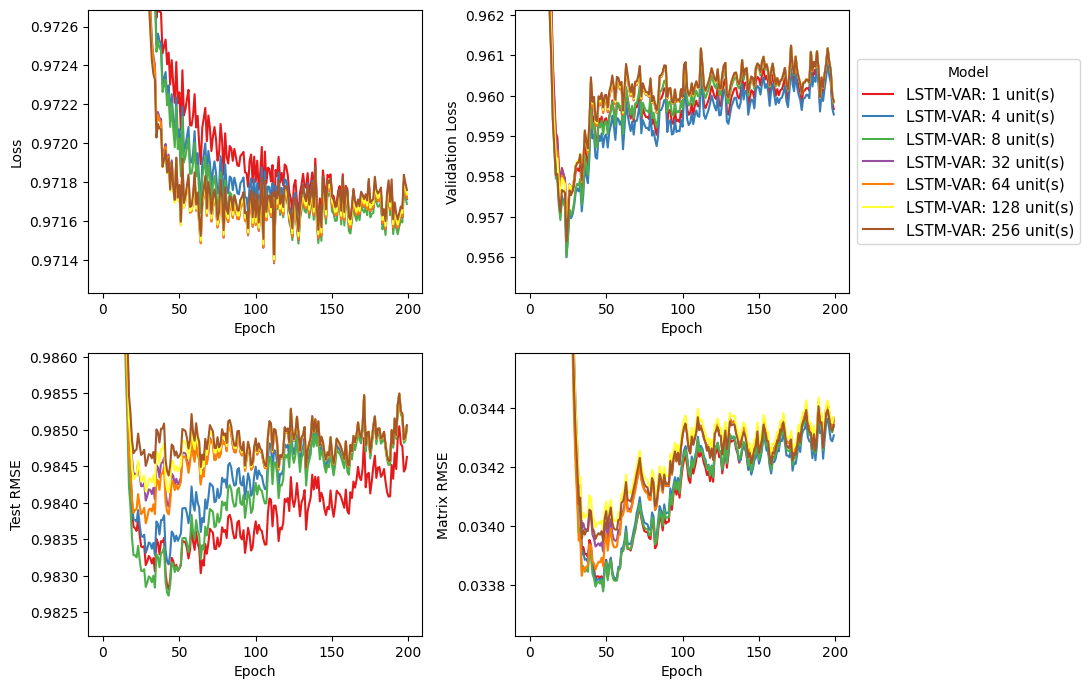

In [7]:
# 1. 2x2 metrics over epochs
fig = plot_performances_over_epochs(metrics, thresholds=[0.2, 0.1, 0.1, 0.2], palette=palette[:len(lstm_vars)])
fig.savefig(test+'/epochs.png')

# Evolution of the loss, validation loss, test RMSE and matrix RMSE over Epochs

In [8]:
var_results.groupby('Model').mean()[['Matrix RMSE', 'Test RMSE', 'Same Sign %']].reindex(vars)

,Matrix RMSE,Test RMSE,Same Sign %
Model,,,
VAR,0.034275,0.982488,0.947222


In [9]:
metrics.groupby(['Model', 'Epoch']).mean()[['Validation Loss', 'Matrix RMSE', 'Test RMSE',  'Same Sign %']].reset_index().groupby(['Model']).min().reindex(lstm_vars)

,Epoch,Validation Loss,Matrix RMSE,Test RMSE,Same Sign %
Model,,,,,
LSTM-VAR: 1 unit(s),0,0.956632,0.033792,0.982815,0.733333
LSTM-VAR: 4 unit(s),0,0.955994,0.033787,0.983158,0.711111
LSTM-VAR: 8 unit(s),0,0.956000,0.033779,0.982731,0.702778
LSTM-VAR: 32 unit(s),0,0.956646,0.033914,0.983952,0.663889
LSTM-VAR: 64 unit(s),0,0.956575,0.033832,0.983720,0.694444
LSTM-VAR: 128 unit(s),0,0.956566,0.033983,0.984143,0.705556
LSTM-VAR: 256 unit(s),0,0.956386,0.033949,0.984374,0.708333


## Gradient analysis
Kernel = what handles the X
Reccurent Kernel = what handles the cell state

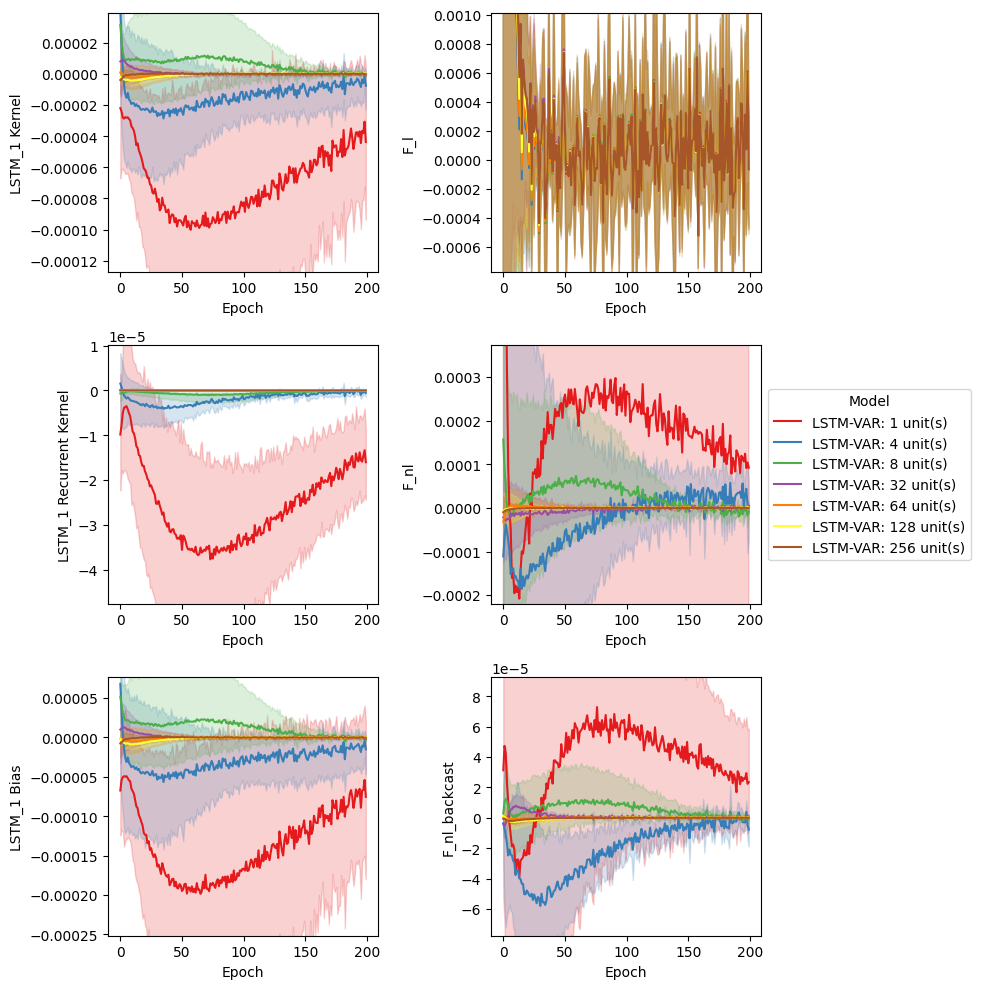

In [12]:
# 2. Gradient over epochs
fig = plot_gradients_over_epochs(gradients, palette[:len(lstm_vars)])
fig.savefig(test+'/gradients.png')

# Evolution of Gradients with Standard Deviation

## Convergence analysis
Table with mean (std), % difference (std) for matrix and val loss.

In [10]:
# 3. Convergence table
converge = compute_convergence(metrics)
table = converge_to_latex_table(converge, lstm_vars)
print(table.style.to_latex())
# Convergence Metrics and Relative Change Across LSTM-VAR Modelsz

Means: Validation Convergence  mean    26.600000
                        std      6.644286
Matrix Convergence      mean    46.171429
                        std     18.097143
Ratio                   mean     1.750000
                        std      0.612857
dtype: float64
\begin{tabular}{llll}
 & Validation Convergence & Matrix Convergence & Ratio \\
Model &  &  &  \\
LSTM-VAR: 1 unit(s) & 27.1 (6.74) & 46.4 (19.02) & 1.72 (0.61) \\
LSTM-VAR: 4 unit(s) & 26.9 (6.51) & 45.1 (14.0) & 1.7 (0.46) \\
LSTM-VAR: 8 unit(s) & 26.2 (6.56) & 45.7 (18.88) & 1.76 (0.68) \\
LSTM-VAR: 32 unit(s) & 26.8 (6.61) & 46.4 (18.97) & 1.73 (0.6) \\
LSTM-VAR: 64 unit(s) & 26.5 (6.7) & 46.4 (18.66) & 1.77 (0.66) \\
LSTM-VAR: 128 unit(s) & 26.3 (6.7) & 47.1 (18.13) & 1.82 (0.68) \\
LSTM-VAR: 256 unit(s) & 26.4 (6.69) & 46.1 (19.02) & 1.75 (0.6) \\
\end{tabular}


Statistical test to see if the relative change between convergences is significantly different between models

In [11]:
# 4. Convergence differences statistical test
groups = converge.groupby('Simulation')['Ratio'].apply(lambda x: x.dropna().values).tolist()
f_statistic, p_value = stats.f_oneway(*groups)
print('Between simulations')
print(f"P-value: {p_value}", f"--- F-statistic: {f_statistic}")

groups = converge.groupby('Model')['Ratio'].apply(lambda x: x.dropna().values).tolist()
f_statistic, p_value = stats.f_oneway(*groups)
print('Between models')
print(f"P-value: {p_value}", f"--- F-statistic: {f_statistic}")
print('Ratio Q3:', converge['Ratio'].quantile(0.90))

Between simulations
P-value: 1.1414650977068196e-40 --- F-statistic: 190.16226441415137
Between models
P-value: 0.9996422559896087 --- F-statistic: 0.043186082786756515
Ratio Q3: 2.2181052631578955


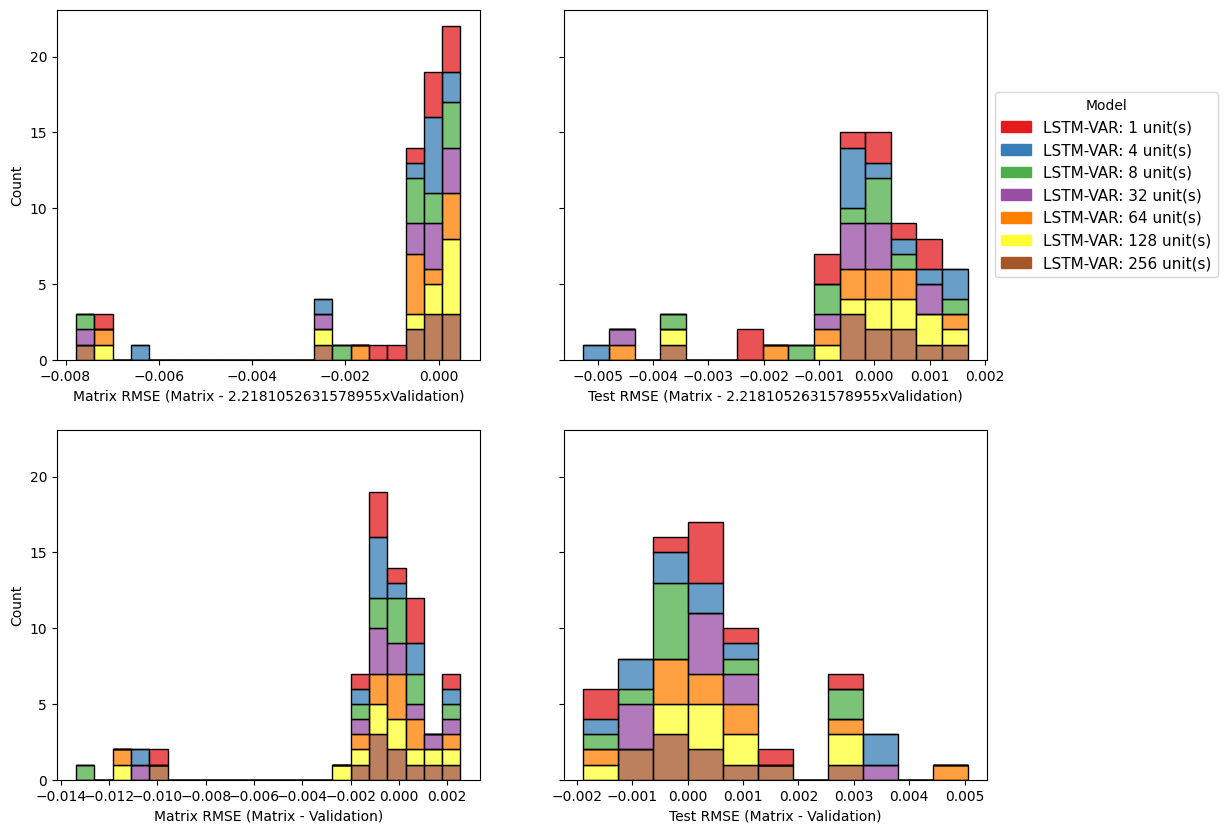

In [19]:
# 5. Convergence metric differences histogram
q3 = np.round(converge['Ratio'].quantile(0.90), 2)
est = get_converged(metrics, converge.set_index(['Model', 'Simulation'])['Validation Convergence']*q3, lstm_vars) # Using Q3 of ratio
mat = get_converged(metrics, converge.set_index(['Model', 'Simulation'])['Matrix Convergence'], lstm_vars)
val = get_converged(metrics, converge.set_index(['Model', 'Simulation'])['Validation Convergence'], lstm_vars)

# Difference between matrix and estimated convergence and between matrix and validation convergence
test_diff = mat[['Matrix RMSE', 'Test RMSE', 'Model', 'Simulation']].reset_index(drop=True)
test_diff.loc[:, f'Test RMSE (Matrix - {q3}xValidation)'] = test_diff['Test RMSE'] - est['Test RMSE']
test_diff.loc[:, f'Matrix RMSE (Matrix - {q3}xValidation)'] = test_diff['Matrix RMSE'] - est['Matrix RMSE']
test_diff.loc[:, 'Test RMSE (Matrix - Validation)'] = test_diff['Test RMSE'] - val['Test RMSE']
test_diff.loc[:, 'Matrix RMSE (Matrix - Validation)'] = test_diff['Matrix RMSE'] - val['Matrix RMSE']
# Re-order
min_diff = order_df((est.sort_values(by=['Model', 'Simulation']).set_index(['Model','Simulation'])[['Matrix RMSE', 'Test RMSE']] - metrics.groupby(['Model', 'Simulation']).min()[['Matrix RMSE', 'Test RMSE']]).reset_index(), lstm_vars)

fig = plot_convergence_differences(
    [{'df':[test_diff, test_diff], 'columns':[f'Matrix RMSE (Matrix - {q3}xValidation)', f'Test RMSE (Matrix - {q3}xValidation)'], 'hue':'Model', 'legend':True, 'palette': palette[:len(lstm_vars)]},
     {'df':[test_diff, test_diff], 'columns':['Matrix RMSE (Matrix - Validation)', 'Test RMSE (Matrix - Validation)'], 'hue':'Model', 'legend':False, 'palette': palette[:len(lstm_vars)]}])
fig.savefig(test+'/convdiff.png')

# Histograms of Differences in Convergence Metrics

In [20]:
print(test_diff.describe()[['Matrix RMSE (Matrix - Validation)', f'Matrix RMSE (Matrix - {q3}xValidation)', 'Test RMSE (Matrix - Validation)', f'Test RMSE (Matrix - {q3}xValidation)']].loc[['min','max']])

     Matrix RMSE (Matrix - Validation)  \
min                          -0.013360   
max                           0.002543   

     Matrix RMSE (Matrix - 2.2181052631578955xValidation)  \
min                                          -0.007774      
max                                           0.000470      

     Test RMSE (Matrix - Validation)  \
min                        -0.001881   
max                         0.005057   

     Test RMSE (Matrix - 2.2181052631578955xValidation)  
min                                          -0.005258   
max                                           0.001690   


## Convergence results

Table of model, matrix sim, test mse (mean (std)), % difference
Table of statistical tests
Heatmap or joyplot plot of variable and lag eucl dist (2 parts)

In [14]:
# 6. Results table
results = pd.concat([val.drop(columns=['Loss', 'Validation Loss', 'Epoch']), var_results])
table = results_to_latex_table(results, lstm_vars, vars)
print(table[['Matrix RMSE', 'Test RMSE']].style.to_latex())

print(table[['Same Sign %']].style.to_latex())
# Performance of LSTM-VAR Models and VAR Models

['VAR']
['VAR']
['VAR']
\begin{tabular}{lllll}
 & \multicolumn{2}{r}{Matrix RMSE} & \multicolumn{2}{r}{Test RMSE} \\
 & Mean & Change (vs VAR) & Mean & Change (vs VAR) \\
Model &  &  &  &  \\
VAR & 0.034 (0.004) & - & 0.982 (0.058) & - \\
LSTM-VAR: 1 unit(s) & 0.034 (0.005) & 0.78\% & 0.983 (0.058) & -0.02\% \\
LSTM-VAR: 4 unit(s) & 0.034 (0.005) & 0.11\% & 0.983 (0.058) & -0.04\% \\
LSTM-VAR: 8 unit(s) & 0.034 (0.006) & 0.06\% & 0.983 (0.058) & -0.0\% \\
LSTM-VAR: 32 unit(s) & 0.034 (0.005) & 0.87\% & 0.984 (0.057) & -0.12\% \\
LSTM-VAR: 64 unit(s) & 0.034 (0.005) & 0.54\% & 0.983 (0.058) & -0.08\% \\
LSTM-VAR: 128 unit(s) & 0.035 (0.005) & -0.68\% & 0.984 (0.058) & -0.13\% \\
LSTM-VAR: 256 unit(s) & 0.034 (0.005) & 0.66\% & 0.984 (0.057) & -0.17\% \\
\end{tabular}

\begin{tabular}{lll}
 & \multicolumn{2}{r}{Same Sign %} \\
 & Mean & Change (vs VAR) \\
Model &  &  \\
VAR & 0.947 (0.046) & - \\
LSTM-VAR: 1 unit(s) & 0.936 (0.051) & 1.17\% \\
LSTM-VAR: 4 unit(s) & 0.936 (0.042) & 1.17\%

In [17]:
# 7. Results p-values table
table = compute_p_values(results, lstm_vars, counterparts)

print(table[['Matrix RMSE', 'Test RMSE', 'Same Sign %']].style.to_latex())
print(table[['Same Sign %']].style.to_latex())
# Statistical Test Results for LSTM-VAR Models vs. VAR Model

\begin{tabular}{llll}
p-value of & Matrix RMSE & Test RMSE & Same Sign % \\
against & VAR & VAR & VAR \\
LSTM-VAR: 1 unit(s) & 0.869 & 0.828 & 0.168 \\
LSTM-VAR: 4 unit(s) & 0.982 & 0.564 & 0.168 \\
LSTM-VAR: 8 unit(s) & 0.991 & 0.963 & 0.168 \\
LSTM-VAR: 32 unit(s) & 0.866 & 0.113 & 0.096 \\
LSTM-VAR: 64 unit(s) & 0.917 & 0.336 & 0.096 \\
LSTM-VAR: 128 unit(s) & 0.897 & 0.146 & 0.051 \\
LSTM-VAR: 256 unit(s) & 0.893 & 0.080 & 0.279 \\
\end{tabular}

\begin{tabular}{ll}
p-value of & Same Sign % \\
against & VAR \\
LSTM-VAR: 1 unit(s) & 0.168 \\
LSTM-VAR: 4 unit(s) & 0.168 \\
LSTM-VAR: 8 unit(s) & 0.168 \\
LSTM-VAR: 32 unit(s) & 0.096 \\
LSTM-VAR: 64 unit(s) & 0.096 \\
LSTM-VAR: 128 unit(s) & 0.051 \\
LSTM-VAR: 256 unit(s) & 0.279 \\
\end{tabular}


## Variable-wise and lag-wise RMSE

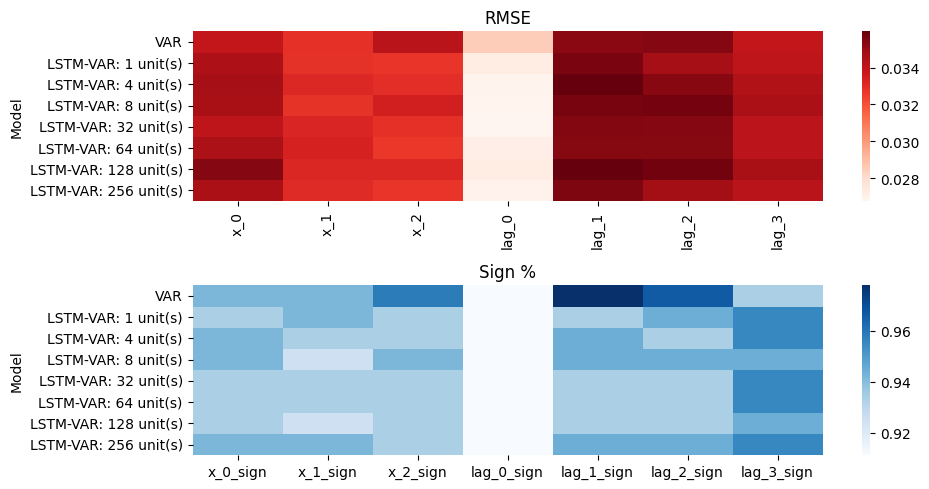

In [18]:
# 8. Variable wise and lag wise heatmap
fig = plot_heatmap(results, vars, lstm_vars, figsize=(10, 5))
fig.savefig(test+'/lags_n_vars.png')

## Forecast breakdown

In [20]:
# 9. Breakdown of forecasts

# Read all models in test/models
models = {file:keras.models.load_model(test+'/models/'+file) for file in os.listdir(test+'/models')}
print(models.keys())

dict_keys(['LSTM-VAR 1 unit(s)', 'LSTM-VAR 128 unit(s)', 'LSTM-VAR 256 unit(s)', 'LSTM-VAR 32 unit(s)', 'LSTM-VAR 4 unit(s)', 'LSTM-VAR 64 unit(s)', 'LSTM-VAR 8 unit(s)'])


In [21]:
# TODO Pick model and what you want to plot
model = models['LSTM-VAR 1 unit(s)']
dgp = 'v' # v, t, s, vt, vs, ts, vts
time_series = 0 # 0 to m-1

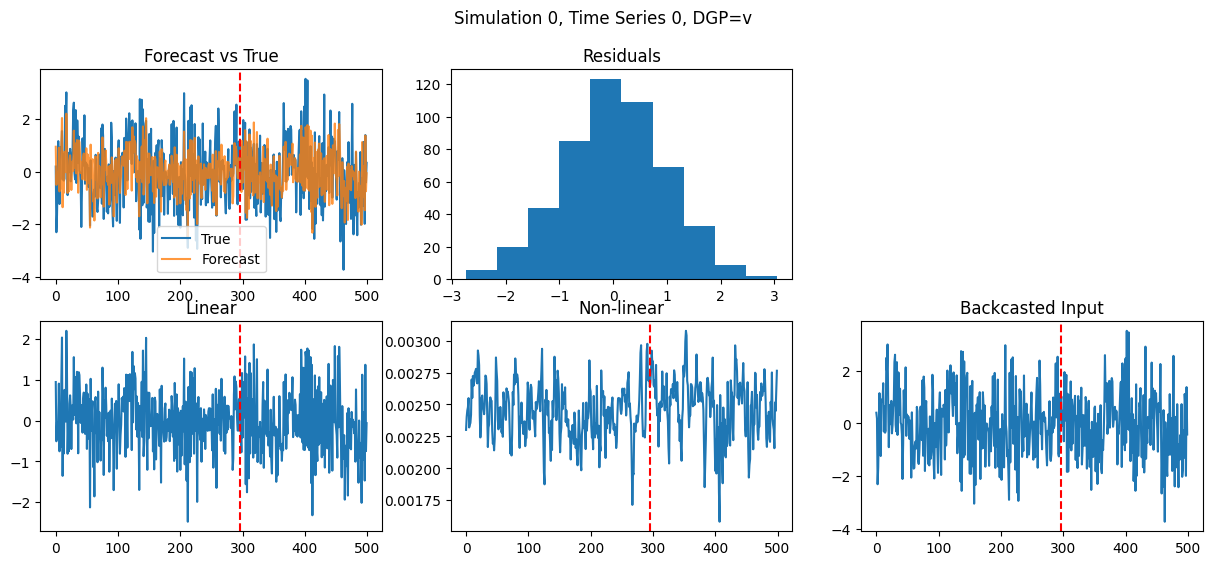

In [22]:
input_window = 4 # depends on model
simulation = simulate(n, m, p, seed=0)
dataset = DataSet(simulation[dgp].values).preprocessing(1, input_window, 0.8, 0.1, scale=False)
fig = plot_forecast_breakdown(model, dataset, time_series, dgp)